# Explore Google Analytics Tracking Data

In [1]:
%load_ext autoreload
%autoreload 2

Import necessary Python modules

In [2]:
import os
import sys
from calendar import month_name

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

Get relative path to project root directory

In [3]:
PROJ_ROOT_DIR = os.path.join(os.pardir)
src_dir = os.path.join(PROJ_ROOT_DIR, "src")
sys.path.append(src_dir)

Import custom Python modules

In [4]:
%aimport bigquery_auth_helpers
from bigquery_auth_helpers import auth_to_bigquery

%aimport transform_helpers
import transform_helpers as th

%aimport viz_helpers
import viz_helpers as vh

## About

This step explores the raw Google Analytics (GA 360) tracking data in order to build up a BigQuery SQL query that returns
- attributes of the first visit to the store
- whether a purchase was made during a return visit to the store

BigQuery SQL is used to retrieve the following
1. how to extract the outcome of return visits
   - this is the label for machine learning
2. how to extract the number of products in a product list that were
   - viewed
   - clicked
3. etc.

## User Inputs

Define the following

1. start and end dates for train and test data to explore return visits
2. end dates for train and test data to explore clickthrough rate by product and visitor
3. list of visit attributes that define a unique visit

In [5]:
# 1. return visits
train_split_start_date = "20160901"
test_split_end_date = "20160930"

# 2. clickthrough rate
train_split_end_date_ctr = "20160902"

# 3. attributes that define a single visit
visit_definition_cols = [
    'fullvisitorid',
    'visitId',
    'visitNumber',
    'visitStartTime',
    'medium',
    'channelGrouping',
    'hits',
    'bounces',
    'pageviews',
    'time_on_site',
    'browser',
    'os',
    'deviceCategory',
]

# 4. GCP resources
gbq_dataset_id = 'mydemo2asdf'
gbq_table_id = 'ecwa'
bucket_name = 'ecwa-raw'

::: {.content-hidden}
Get path to data sub-folders
:::

In [6]:
gcp_proj_id = os.environ["GCP_PROJECT_ID"]
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
gcp_keys_dir = os.path.join(PROJ_ROOT_DIR, "gcp_keys")

In [7]:
gbq_table_fully_resolved = f"{gcp_proj_id}.{gbq_dataset_id}.{gbq_table_id}"

::: {.content-hidden}
Create a mapping between action type integer and label, in order to get meaningful names from the `action_type` column
:::

In [8]:
action_mapper = {
    1: "Click through of product lists",
    2: "Product detail views",
    3: "Add product(s) to cart",
    4: "Remove product(s) from cart",
    5: "Check out",
    6: "Completed purchase",
    7: "Refund of purchase",
    8: "Checkout options",
    0: "Unknown",
}

## Authenticate to `BigQuery`

In [9]:
gcp_auth_dict = auth_to_bigquery(gcp_keys_dir)

## Explore Google Analytics Tracking Data

### Get Return Visit Outcome

Get the outcome of all return visits during September 2016

In [10]:
query_str = f"""
            WITH
            return_visits AS (
                 SELECT fullvisitorid,
                        visitId,
                        visitNumber,
                        DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                        IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, True, False) AS made_purchase_on_future_visit
                 -- FROM `data-to-insights.ecommerce.web_analytics`
                 FROM {gbq_table_fully_resolved}
                 WHERE date BETWEEN '{train_split_start_date}' AND '{test_split_end_date}'
                 AND geoNetwork.country = 'United States'
                 GROUP BY fullvisitorid,
                          visitId,
                          visitNumber,
                          visitStartTime
            )
            SELECT *
            FROM return_visits
            ORDER BY fullvisitorid
            """
df = th.extract_data(query_str, gcp_auth_dict)
df.head()

Query execution start time = 2023-07-17 21:05:15.202...done at 2023-07-17 21:05:18.130 (2.928 seconds).
Query returned 28,013 rows


,fullvisitorid,visitId,visitNumber,visitStartTime,made_purchase_on_future_visit
0,0000093957001069502,1474985724,1,2016-09-27 07:15:24,False
1,0000245437374675368,1472862842,1,2016-09-02 17:34:02,False
2,0000639845445148063,1473694653,1,2016-09-12 08:37:33,False
3,000139156957304532,1473013369,1,2016-09-04 11:22:49,False
4,0001601342180848204,1474930306,1,2016-09-26 15:51:46,False


Get visitors who made multiple return visits

In [11]:
df_return_visits = df[df.duplicated(subset=["fullvisitorid"], keep=False)]
df_return_visits.head(10)

,fullvisitorid,visitId,visitNumber,visitStartTime,made_purchase_on_future_visit
12,0005884918507288420,1474464720,1,2016-09-21 06:32:00,False
13,0005884918507288420,1474469723,2,2016-09-21 07:55:23,False
19,0010286039787739137,1475084026,1,2016-09-28 10:33:46,False
20,0010286039787739137,1475249827,2,2016-09-30 08:37:07,False
32,0015065858137292339,1473119040,2,2016-09-05 16:44:00,False
33,0015065858137292339,1473997381,6,2016-09-15 20:43:01,False
34,0015065858137292339,1473630321,4,2016-09-11 14:45:21,False
35,0015065858137292339,1472856937,1,2016-09-02 15:55:37,False
36,0015065858137292339,1473641554,5,2016-09-11 17:52:34,False
37,0015065858137292339,1473466324,3,2016-09-09 17:12:04,False


Return visits are made up by two types of visitors

1. those that made a purchase
2. those that did not make a purchase

The number of visitors who did and did not make a purchase during a return visit are shown below

In [12]:
df_return_visits["made_purchase_on_future_visit"].value_counts().reset_index().assign(
    proportion=lambda df: df["count"] / df["count"].sum()
)

,made_purchase_on_future_visit,count,proportion
0,False,10507,0.955616
1,True,488,0.044384


::: {.callout-tip title="Observations"}

1. Only approximately 4.4% of all return visits in September 2016 resulted in a purchase.
:::

### Show Frequency of Repeat Customers During Return Visits

Some visitors made multiple return visits and a small subset of such visitors made multiple purchases. This is shown below.

First, for each visitor, get the following

1. whether that vistor ever made a purchase on a return visit
2. number of purchases made across all return visits

In [13]:
df_return_visits_with_purchase = df_return_visits.groupby(
    "fullvisitorid", as_index=False
).agg({"made_purchase_on_future_visit": ["max", "sum"]})
df_return_visits_with_purchase.columns = [
    "_".join(a).rstrip("_")
    for a in df_return_visits_with_purchase.columns.to_flat_index()
]
df_return_visits_with_purchase

,fullvisitorid,made_purchase_on_future_visit_max,made_purchase_on_future_visit_sum
0,0005884918507288420,False,0
1,0010286039787739137,False,0
2,0015065858137292339,False,0
3,0026203741366904270,True,1
4,0027817676806595220,False,0
...,...,...,...
3755,9986848664463401272,False,0
3756,9990362099175067703,False,0
3757,999203594099745000,False,0
3758,9992704342633956099,False,0


Next, get visitors who made a purchase on a return visit

In [14]:
df_return_visits_with_purchase = df_return_visits_with_purchase.query(
    "made_purchase_on_future_visit_max == True"
)
df_return_visits_with_purchase

,fullvisitorid,made_purchase_on_future_visit_max,made_purchase_on_future_visit_sum
3,0026203741366904270,True,1
7,0036417634769000138,True,1
8,0037518757923116572,True,1
14,0061519776091452595,True,1
19,0070976956518566605,True,1
...,...,...,...
3709,9891815404632176641,True,1
3718,9912185644936709935,True,1
3725,9941749289816017941,True,1
3742,9961396584113412108,True,1


::: {.callout-note title="Notes"}

1. `made_purchase_on_future_visit` indicates if a purchase was made during a return visit.
2. `made_purchase_on_future_visit_max` indicates whether a visitor who made a return visit to the store made a purchase during any such visit.
3. `made_purchase_on_future_visit_sum` shows the total number of purchases made by a visitor across all return visits.
:::

Finally, filter the occurrences of return visits during September 2016 to only capture all visitors who made **a purchase on multiple return visits**

In [15]:
df_return_visits_merged = df_return_visits.merge(
    df_return_visits_with_purchase, on=["fullvisitorid"], how="inner"
)

Visitors who made a purchase on multiple return visits are shown below

In [16]:
df_return_visits_merged.query("made_purchase_on_future_visit_sum > 2").head(15)

,fullvisitorid,visitId,visitNumber,visitStartTime,made_purchase_on_future_visit,made_purchase_on_future_visit_max,made_purchase_on_future_visit_sum
316,2074164338647079047,1472746638,18,2016-09-01 09:17:18,False,True,4
317,2074164338647079047,1473792585,21,2016-09-13 11:49:45,True,True,4
318,2074164338647079047,1473446196,20,2016-09-09 11:36:36,True,True,4
319,2074164338647079047,1472739238,17,2016-09-01 07:13:58,False,True,4
320,2074164338647079047,1472735454,16,2016-09-01 06:10:54,False,True,4
321,2074164338647079047,1473196307,19,2016-09-06 14:11:47,True,True,4
322,2074164338647079047,1474310682,22,2016-09-19 11:44:42,False,True,4
323,2074164338647079047,1474373863,23,2016-09-20 05:17:43,True,True,4
535,280738376597848400,1473903584,5,2016-09-14 18:39:44,True,True,3
536,280738376597848400,1473878689,3,2016-09-14 11:44:49,False,True,3


::: {.callout-tip title="Observations"}

1. We can see that these are the subset of return visitors who made a purchase on multiple return visits since the values in the `made_purchase_on_future_visit_sum` column that are larger than 1.
:::

For visitors who who made a purchae on multiple return visits, show the number of visitors who made a purchase on a single such visit and those that made a purchase during multiple such visits

In [17]:
df_return_visits_merged.assign(
    made_purchase_on_multiple_return_visits=lambda df: df[
        "made_purchase_on_future_visit_sum"
    ]
    > 1
).groupby("made_purchase_on_multiple_return_visits", as_index=False)[
    "fullvisitorid"
].count().rename(
    columns={"fullvisitorid": "count"}
).assign(
    proportion=lambda df: df["count"] / df["count"].sum()
)

,made_purchase_on_multiple_return_visits,count,proportion
0,False,1385,0.835344
1,True,273,0.164656


::: {.callout-tip title="Observations"}

1. Most visitors who made a purchae on multiple return visits during September 2016 only made a purchase during one of thse visits. Only approximately 16% of such visitors made a purchase during multiple such visits.
2. The SQL logic defined above is capturing repeat customers. These are visitors who made a purchase during more than one visit to the store. This is required per the scope of this project since the business wants to grow both repeat as well as new customers.
:::

### Product List Clickthrough Rate

Get the following product-related actions performed per visit
- `productListName`
- `productListPosition`
- `isImpression`
- `isClick`

In [18]:
query_str = f"""
            WITH
            -- Step 1. get visitors with a return visit
            returning_visitors AS (
                 SELECT fullvisitorid,
                        IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, True, False) AS made_purchase_on_future_visit
                 -- FROM `data-to-insights.ecommerce.web_analytics`
                 FROM {gbq_table_fully_resolved}
                 WHERE date BETWEEN '{train_split_start_date}' AND '{test_split_end_date}'
                 AND geoNetwork.country = 'United States'
                 GROUP BY fullvisitorid
            ),
            -- Steps 2. and 3. get attributes of the first visit
            first_visit_attributes AS (
                SELECT -- =========== GEOSPATIAL AND TEMPORAL ATTRIBUTES OF VISIT ===========
                       geoNetwork.country,
                       -- =========== VISIT AND VISITOR METADATA ===========
                       fullvisitorid,
                       visitId,
                       visitNumber,
                       DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                       -- =========== SOURCE OF SITE TRAFFIC ===========
                       -- source of the traffic from which the visit was initiated
                       trafficSource.source,
                       -- medium of the traffic from which the visit was initiated
                       trafficSource.medium,
                       -- referring channel connected to visit
                       channelGrouping,
                       -- =========== VISITOR ACTIVITY ===========
                       -- total number of hits
                       (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                       -- number of bounces
                       -- action performed during first visit
                       CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                       (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                       -- page views
                       IFNULL(totals.pageviews, 0) AS pageviews,
                       -- time on the website
                       IFNULL(totals.timeOnSite, 0) AS time_on_site,
                       -- =========== VISITOR DEVICES ===========
                       -- user's browser
                       device.browser,
                       -- user's operating system
                       device.operatingSystem AS os,
                       -- user's type of device
                       device.deviceCategory,
                       -- =========== PRODUCT ===========
                       h.product,
                       -- =========== ML LABEL (DEPENDENT VARIABLE) ===========
                       made_purchase_on_future_visit
                -- FROM `data-to-insights.ecommerce.web_analytics`
                FROM {gbq_table_fully_resolved},
                UNNEST(hits) AS h
                INNER JOIN returning_visitors USING (fullvisitorid)
                WHERE date BETWEEN '{train_split_start_date}' AND '{train_split_end_date_ctr}'
                AND geoNetwork.country = 'United States'
                AND totals.newVisits = 1
            )
            SELECT fullvisitorid,
                   visitId,
                   visitNumber,
                   visitStartTime,
                   medium,
                   channelGrouping,
                   hits,
                   bounces,
                   action_type,
                   pageviews,
                   time_on_site,
                   browser,
                   os,
                   deviceCategory,
                   pu.productListName,
                   pu.productListPosition,
                   pu.isImpression,
                   pu.isClick
            FROM first_visit_attributes
            LEFT JOIN UNNEST(product) as pu
            """
df_actions = (
    th.extract_data(query_str, gcp_auth_dict)
    .assign(action_type=lambda df: df['action_type'].map(action_mapper))
)
df_actions

Query execution start time = 2023-07-17 21:05:18.326...done at 2023-07-17 21:05:29.568 (11.242 seconds).
Query returned 110,949 rows


,fullvisitorid,visitId,visitNumber,visitStartTime,medium,channelGrouping,hits,bounces,action_type,pageviews,time_on_site,browser,os,deviceCategory,productListName,productListPosition,isImpression,isClick
0,0316311707782728622,1472753138,1,2016-09-01 11:05:38,organic,Organic Search,1,1,Unknown,1,0,Chrome,Windows,desktop,None,<NA>,<NA>,<NA>
1,6168614871318887654,1472713655,1,2016-09-01 00:07:35,organic,Organic Search,1,1,Unknown,1,0,Chrome,Macintosh,desktop,None,<NA>,<NA>,<NA>
2,0504414286758319636,1472812649,1,2016-09-02 03:37:29,organic,Organic Search,1,1,Unknown,1,0,Chrome,Windows,desktop,None,<NA>,<NA>,<NA>
3,4688709090556969382,1472868664,1,2016-09-02 19:11:04,referral,Social,1,1,Unknown,1,0,Edge,Windows,desktop,None,<NA>,<NA>,<NA>
4,5995066090171502115,1472761927,1,2016-09-01 13:32:07,organic,Organic Search,1,1,Unknown,1,0,Internet Explorer,Windows,desktop,None,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110944,1148068114291324080,1472833979,1,2016-09-02 09:32:59,referral,Social,3,0,Unknown,3,28,Safari,Macintosh,desktop,Category,33,True,<NA>
110945,1148068114291324080,1472833979,1,2016-09-02 09:32:59,referral,Social,3,0,Unknown,3,28,Safari,Macintosh,desktop,Category,34,True,<NA>
110946,811117071146794755,1472871830,1,2016-09-02 20:03:50,referral,Social,1,1,Unknown,1,0,Safari (in-app),iOS,mobile,None,<NA>,<NA>,<NA>
110947,0514824820143754671,1472861901,1,2016-09-02 17:18:21,referral,Social,1,1,Unknown,1,0,Safari,Macintosh,desktop,None,<NA>,<NA>,<NA>


Show the number of unique values in the `isImpression` and `isClick` columns

In [19]:
for c in ['isImpression', 'isClick']:
    print(c, df_actions[c].unique().tolist())

isImpression [<NA>, True]
isClick [<NA>, True]


Show all visits with a product click

In [20]:
display(df_actions.query("isClick == True"))

,fullvisitorid,visitId,visitNumber,visitStartTime,medium,channelGrouping,hits,bounces,action_type,pageviews,time_on_site,browser,os,deviceCategory,productListName,productListPosition,isImpression,isClick
1591,093437836654213633,1472857366,1,2016-09-02 16:02:46,organic,Organic Search,3,0,Click through of product lists,2,18,Safari,iOS,mobile,Category,0,<NA>,True
1601,0962511771321073901,1472766824,1,2016-09-01 14:53:44,organic,Organic Search,3,0,Click through of product lists,2,14,Internet Explorer,Windows,desktop,Category,0,<NA>,True
2586,4319626089813089608,1472885271,1,2016-09-02 23:47:51,organic,Organic Search,3,0,Click through of product lists,2,31,Chrome,Windows,desktop,Category,0,<NA>,True
3092,472296335518463005,1472861227,1,2016-09-02 17:07:07,organic,Organic Search,3,0,Click through of product lists,2,8,Safari,iOS,mobile,Category,0,<NA>,True
3128,5838352765027730517,1472765549,1,2016-09-01 14:32:29,organic,Organic Search,3,0,Click through of product lists,2,72,Safari,iOS,mobile,Category,0,<NA>,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105059,0490491717591043585,1472725245,1,2016-09-01 03:20:45,(none),Direct,4,0,Click through of product lists,3,159,Chrome,Android,mobile,Category,0,<NA>,True
106196,9272873752801415669,1472853858,1,2016-09-02 15:04:18,(none),Direct,5,0,Click through of product lists,4,73,Chrome,Macintosh,desktop,Category,0,<NA>,True
106307,9635764741243626250,1472740983,1,2016-09-01 07:43:06,(none),Direct,5,0,Click through of product lists,3,503,Chrome,Linux,desktop,Category,0,<NA>,True
109058,9074094202316196072,1472758664,1,2016-09-01 12:37:44,organic,Organic Search,4,0,Click through of product lists,3,27,Chrome,Windows,desktop,Category,0,<NA>,True


Get two visits with a product click

In [21]:
visits_with_click = df_actions.query("isClick == True")['visitId'].unique().tolist()
visitIds_clicked = np.random.choice(visits_with_click, size=2, replace=False).tolist()

Show two visits with a product click

In [22]:
with pd.option_context('display.max_rows', None):
    display(df_actions.query("visitId.isin(@visitIds_clicked)"))

,fullvisitorid,visitId,visitNumber,visitStartTime,medium,channelGrouping,hits,bounces,action_type,pageviews,time_on_site,browser,os,deviceCategory,productListName,productListPosition,isImpression,isClick
69266,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,None,<NA>,<NA>,<NA>
69267,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,1,True,<NA>
69268,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,2,True,<NA>
69269,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,3,True,<NA>
69270,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,4,True,<NA>
69271,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,5,True,<NA>
69272,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,6,True,<NA>
69273,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,7,True,<NA>
69274,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,8,True,<NA>
69275,6104958222751020162,1472791820,1,2016-09-01 21:50:20,(none),Direct,29,0,Unknown,18,496,Chrome,Chrome OS,desktop,Category,9,True,<NA>


Product clicks are not observed for the `Unknown` action type, as shown below

In [23]:
assert df_actions.query("action_type == 'Unknown'").query("isClick == True").empty

Calculate the product clickthrough rate (CTR) for all products [in a product list](https://metriclabs.com.au/glossary/analytics-metrics/product-list-views/) across these two visits

In [24]:
(
    df_actions.query("visitId.isin(@visitIds_clicked)")
    .groupby("visitId", as_index=False)
    .agg({'isImpression': 'sum', 'isClick': 'sum'})
    .rename(columns={"isClick": "clicks", "isImpression": "views"})
    .assign(product_ctr=lambda df: 100*(df['clicks']/df['views']))
)

,visitId,views,clicks,product_ctr
0,1472791820,93,11,11.827957
1,1472840648,243,12,4.938272


Using Python, calculate the clickthrough rate (CTR) for all products in a product list across all visits
- by product
  - number of products that were clicked in a product list / number of products that were viewed a product list
- by visitor
  - number of visitors who clicked a product in a product list / number of visitors who viewed a product list

In [25]:
df_summary_actions = (
    pd.DataFrame.from_dict(
        {
            "num_visitors": df_actions["fullvisitorid"].nunique(),
            "actions": len(df_actions.query("action_type != 'Unknown'")),
            # views by product
            "product_views": df_actions["isImpression"].sum(),
            # clicks by product
            "product_clicks": df_actions["isClick"].sum(),
            # views by visitor
            'visitor_views': (
                len(
                    df_actions.query("(action_type != 'Click through of product lists') & (isImpression == True)")
                    .drop_duplicates(subset=visit_definition_cols, keep='first')
                )
            ),
            # clicks by visitor
            'visitor_clicks': (
                len(
                    df_actions.query("(action_type == 'Click through of product lists') & (isClick == True)")
                    .drop_duplicates(subset=visit_definition_cols, keep='first')
                )
            )
        },
        orient='index',
    )
    .transpose()
    # CTR by product
    .assign(product_ctr=lambda df: 100*(df['product_clicks']/df['product_views']))
    # CTR by visitor
    .assign(visitor_ctr=lambda df: 100*(df['visitor_clicks']/df['visitor_views']))
)
df_summary_actions

,num_visitors,actions,product_views,product_clicks,visitor_views,visitor_clicks,product_ctr,visitor_ctr
0,1359,4104,103119,1717,911,379,1.665067,41.602634


Get the following aggregated product-related actions performed per visit
- product views
- product clicks

In [26]:
query_str = f"""
            WITH
            -- Step 1. get visitors with a return visit
            returning_visitors AS (
                 SELECT fullvisitorid,
                        IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, True, False) AS made_purchase_on_future_visit
                 -- FROM `data-to-insights.ecommerce.web_analytics`
                 FROM {gbq_table_fully_resolved}
                 WHERE date BETWEEN '{train_split_start_date}' AND '{test_split_end_date}'
                 AND geoNetwork.country = 'United States'
                 GROUP BY fullvisitorid
            ),
            -- Steps 2. and 3. get attributes of the first visit
            first_visit_attributes AS (
                SELECT -- =========== GEOSPATIAL AND TEMPORAL ATTRIBUTES OF VISIT ===========
                       geoNetwork.country,
                       -- =========== VISIT AND VISITOR METADATA ===========
                       fullvisitorid,
                       visitId,
                       visitNumber,
                       DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                       -- =========== SOURCE OF SITE TRAFFIC ===========
                       -- source of the traffic from which the visit was initiated
                       trafficSource.source,
                       -- medium of the traffic from which the visit was initiated
                       trafficSource.medium,
                       -- referring channel connected to visit
                       channelGrouping,
                       -- =========== VISITOR ACTIVITY ===========
                       -- total number of hits
                       (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                       -- number of bounces
                       -- action performed during first visit
                       CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                       (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                       -- page views
                       IFNULL(totals.pageviews, 0) AS pageviews,
                       -- time on the website
                       IFNULL(totals.timeOnSite, 0) AS time_on_site,
                       -- =========== VISITOR DEVICES ===========
                       -- user's browser
                       device.browser,
                       -- user's operating system
                       device.operatingSystem AS os,
                       -- user's type of device
                       device.deviceCategory,
                       -- =========== PRODUCT ===========
                       h.product,
                       -- =========== ML LABEL (DEPENDENT VARIABLE) ===========
                       made_purchase_on_future_visit
                -- FROM `data-to-insights.ecommerce.web_analytics`
                FROM {gbq_table_fully_resolved},
                UNNEST(hits) AS h
                INNER JOIN returning_visitors USING (fullvisitorid)
                WHERE date BETWEEN '{train_split_start_date}' AND '{train_split_end_date_ctr}'
                AND geoNetwork.country = 'United States'
                AND totals.newVisits = 1
            ),
            -- Step 4. get aggregated features (attributes) per visit
            visit_attributes AS (
                SELECT fullvisitorid,
                       visitId,
                       visitNumber,
                       visitStartTime,
                       medium,
                       channelGrouping,
                       hits,
                       bounces,
                       MAX(action_type) AS last_action,
                       pageviews,
                       time_on_site,
                       browser,
                       os,
                       deviceCategory,
                       -- get number of products displayed and clicked during the first visit
                       -- (option 1) USING SUM()
                       -- SUM(CASE WHEN pu.isImpression IS TRUE THEN 1 ELSE 0 END) AS product_views,
                       -- SUM(CASE WHEN pu.isClick IS TRUE THEN 1 ELSE 0 END) AS product_clicks,
                       -- (option 2) USING COUNT()
                       COUNT(CASE WHEN pu.isImpression IS NULL THEN NULL ELSE 1 END) AS product_views,
                       COUNT(CASE WHEN pu.isClick IS NULL THEN NULL ELSE 1 END) AS product_clicks
                FROM first_visit_attributes
                LEFT JOIN UNNEST(product) as pu
                GROUP BY fullvisitorid,
                         visitId,
                         visitNumber,
                         visitStartTime,
                         medium,
                         channelGrouping,
                         hits,
                         bounces,
                         pageviews,
                         time_on_site,
                         browser,
                         os,
                         deviceCategory
            )
            SELECT *
            FROM visit_attributes
            """
df_visitors = (
    th.extract_data(query_str, gcp_auth_dict)
    .assign(last_action=lambda df: df['last_action'].map(action_mapper))
)
df_visitors

Query execution start time = 2023-07-17 21:05:29.904...done at 2023-07-17 21:05:31.173 (1.270 seconds).
Query returned 1,360 rows


,fullvisitorid,visitId,visitNumber,visitStartTime,medium,channelGrouping,hits,bounces,last_action,pageviews,time_on_site,browser,os,deviceCategory,product_views,product_clicks
0,3322420343273401546,1472754644,1,2016-09-01 11:30:44,referral,Referral,1,1,Unknown,1,0,Chrome,Macintosh,desktop,0,0
1,9862343542176956731,1472771192,1,2016-09-01 16:06:32,cpc,Paid Search,1,1,Unknown,1,0,Safari,iOS,tablet,0,0
2,2102352523558054189,1472746173,1,2016-09-01 09:09:33,organic,Organic Search,1,1,Unknown,1,0,Firefox,Windows,desktop,34,0
3,4995485940498774034,1472739846,1,2016-09-01 07:24:06,organic,Organic Search,1,1,Unknown,1,0,Chrome,Android,mobile,0,0
4,2720302308831212073,1472836768,1,2016-09-02 10:19:28,organic,Organic Search,1,1,Unknown,1,0,Internet Explorer,Windows,desktop,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,9220747477042639132,1472800520,1,2016-09-02 00:15:20,referral,Social,1,1,Unknown,1,0,Chrome,Macintosh,desktop,0,0
1356,1063228903355577074,1472832136,1,2016-09-02 09:02:16,referral,Social,2,0,Unknown,2,50,Safari,Macintosh,desktop,0,0
1357,8702608160335187479,1472768781,1,2016-09-01 15:26:21,referral,Social,2,0,Unknown,2,53,Chrome,Windows,desktop,0,0
1358,306040510252665592,1472827690,1,2016-09-02 07:48:10,referral,Social,2,0,Unknown,2,48,Safari,Macintosh,desktop,0,0


::: {.callout-note title="Notes"}

1. From the [datset documentation](https://support.google.com/analytics/answer/3437719?hl=en) for the **Field Name** `hits.eCommerceAction.action_type`, in order to calculate number of products in a product list it is sufficient to use the SQL conditional `WHERE hits.product.isImpression == TRUE`. This was used as part of a `CASE WHEN` in option 1 with the `SUM()` aggregation function to count the number of products in a product list that were viewed. Alternatively, since the SQL [`COUNT()` function counts non-`NULL` values](https://stackoverflow.com/a/1354071/4057186), this function could also be used to get the same result, as shown in the two commented lines in option 2.
2. Similar logic for product views is also used to get the number of products in a product list that were clicked.
:::

Repeat the Python calculation of the clickthrough rate (CTR) for all products in a product list across all visits
- by product
- by visitor

using the aggregated visits data retrieved, where the calculation is performed using SQL

In [27]:
df_summary_actions_sql = (
    pd.DataFrame.from_dict(
        {
            "num_visitors": df_visitors["fullvisitorid"].nunique(),
            # views by product
            "product_views": df_visitors['product_views'].sum(),
            # clicks by product
            "product_clicks": df_visitors['product_clicks'].sum(),
            # views by visitor
            "visitor_views": (
                len(
                    df_visitors.query("product_views > 0")
                    .drop_duplicates(subset=visit_definition_cols, keep='first')
                )
            ),
            # clicks by visitor
            "visitor_clicks": (
                len(
                    df_visitors.query("product_clicks > 0")
                    .drop_duplicates(subset=visit_definition_cols, keep='first')
                )
            ),
        },
        orient='index',
    )
    .transpose()
    # CTR by product
    .assign(product_ctr=lambda df: 100*(df['product_clicks']/df['product_views']))
    # CTR by visitor
    .assign(visitor_ctr=lambda df: 100*(df['visitor_clicks']/df['visitor_views']))
)
df_summary_actions_sql

,num_visitors,product_views,product_clicks,visitor_views,visitor_clicks,product_ctr,visitor_ctr
0,1359,103119,1717,911,379,1.665067,41.602634


Verify that the CTR by products and visitors calculated using visits aggregated with
- Python
- SQL

are equivalent

In [28]:
assert df_summary_actions.drop(columns=['actions']).equals(df_summary_actions_sql)

### Monthly KPIs

Get the following monthly KPIs across all visitors

1. number of visitors
2. revenue (USD)
3. bounce rate
4. conversion rate
5. product CTR
6. promotions ctr
7. return purchaser rate
8. return visitor rate

In [29]:
query_str = f"""
            WITH raw_visit_attributes AS (
                SELECT -- =========== GEOSPATIAL ATTRIBUTES OF VISIT ===========
                       geoNetwork.country,
                       -- =========== VISIT AND VISITOR METADATA ===========
                       fullvisitorid,
                       visitId,
                       visitNumber,
                       DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                       -- =========== SOURCE OF SITE TRAFFIC ===========
                       -- source of the traffic from which the visit was initiated
                       trafficSource.source,
                       -- medium of the traffic from which the visit was initiated
                       trafficSource.medium,
                       -- referring channel connected to visit
                       channelGrouping,
                       -- =========== VISITOR ACTIVITY ===========
                       -- total number of hits
                       (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                       -- number of bounces
                       (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                       -- action performed during visit
                       CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                       -- page views
                       IFNULL(totals.pageviews, 0) AS pageviews,
                       -- time on the website
                       IFNULL(totals.timeOnSite, 0) AS time_on_site,
                       -- whether add-to-cart was performed during visit
                       (CASE WHEN CAST(h.eCommerceAction.action_type AS INT64) = 3 THEN 1 ELSE 0 END) AS added_to_cart,
                       -- =========== VISITOR DEVICES ===========
                       -- user's browser
                       device.browser,
                       -- user's operating system
                       device.operatingSystem AS os,
                       -- user's type of device
                       device.deviceCategory,
                       -- =========== PROMOTION ===========
                       h.promotion,
                       h.promotionActionInfo AS pa_info,
                       -- =========== PRODUCT ===========
                       h.product,
                       --=========== OTHER ===========
                       -- whether a the visitor made a purchase
                       totals.transactions,
                       -- get column needed to determine if visitor is a return purchaser
                       totals.newVisits,
                       -- whether the action performed was a purchase
                       (CASE WHEN totals.transactions IS NOT NULL THEN 1 ELSE 0 END) AS is_purchase
                -- FROM `data-to-insights.ecommerce.web_analytics`,
                FROM {gbq_table_fully_resolved},
                UNNEST(hits) AS h
                WHERE date BETWEEN '20160801' AND '20170731'
                AND geoNetwork.country = 'United States'
            ),
            agg_visit_attributes AS (
                SELECT fullvisitorid,
                       visitId,
                       visitNumber,
                       visitStartTime,
                       EXTRACT(YEAR FROM visitStartTime) AS year,
                       EXTRACT(MONTH FROM visitStartTime) AS month,
                       source,
                       medium,
                       channelGrouping,
                       hits,
                       bounces,
                       -- get the last action performed during visit
                       -- (this indicates where the visitor left off at the end of their visit)
                       MAX(action_type) AS last_action,
                       -- get number of promotions displayed and clicked during visit
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsView ELSE NULL END) AS promos_displayed,
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsClick ELSE NULL END) AS promos_clicked,
                       -- get number of products displayed and clicked during visit
                       COUNT(CASE WHEN pu.isImpression IS NULL THEN NULL ELSE 1 END) AS product_views,
                       COUNT(CASE WHEN pu.isClick IS NULL THEN NULL ELSE 1 END) AS product_clicks,
                       pageviews,
                       time_on_site,
                       browser,
                       os,
                       deviceCategory,
                       SUM(added_to_cart) AS added_to_cart,
                       SUM(pu.localProductRevenue/1000000) AS revenue,
                       -- check if visitor made a return purchase
                       IF(COUNTIF(transactions > 0 AND newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit,
                       -- get purchases during visit
                       SUM(is_purchase) AS purchases
                FROM raw_visit_attributes
                LEFT JOIN UNNEST(promotion) as p
                LEFT JOIN UNNEST(product) as pu
                GROUP BY fullvisitorid,
                         visitId,
                         visitNumber,
                         visitStartTime,
                         year,
                         month,
                         source,
                         medium,
                         channelGrouping,
                         hits,
                         bounces,
                         pageviews,
                         time_on_site,
                         browser,
                         os,
                         deviceCategory
            ),
            monthly_kpis AS (
                SELECT 'all' AS visitor_type,
                       year,
                       month,
                       CONCAT(year, '-', SUBSTR(format_date('%B', date(2016, month, 1)), 1, 3)) AS year_month,
                       -- number of unique visitors
                       COUNT(DISTINCT fullVisitorId) AS visitors,
                       -- get KPIs across all visitors at the visit level (i.e. capture multiple visits by same visitor)
                       ROUND(SUM(revenue),2) AS revenue,
                       -- need MAX() since we only want to determine if visitor was a purchaser or not
                       -- MAX(purchases) AS purchasers,
                       100 * (SUM(bounces) / COUNT(fullVisitorId)) AS bounce_rate,
                       100 * (MAX(purchases) / COUNT(fullVisitorId)) AS conversion_rate,
                       100 * (SUM(product_clicks) / SUM(product_views)) AS product_ctr,
                       100 * (SUM(promos_clicked) / SUM(promos_displayed)) AS promos_ctr,
                       100 * (SUM(will_buy_on_return_visit) / COUNT(fullVisitorId)) AS return_purchaser_rate,
                       100 * (SUM(CASE WHEN will_buy_on_return_visit = 0 THEN 1 ELSE 0 END) / COUNT(fullVisitorId)) AS return_visitor_rate
                FROM agg_visit_attributes
                GROUP BY year, month
                ORDER BY year, month
            )
            SELECT * EXCEPT(month)
            FROM monthly_kpis
            """
df_all_visitors = th.extract_data(query_str, gcp_auth_dict)
with pd.option_context('display.max_columns', None):
    display(df_all_visitors)

Query execution start time = 2023-07-17 21:05:31.256...done at 2023-07-17 21:05:34.913 (3.657 seconds).
Query returned 12 rows


,visitor_type,year,year_month,visitors,revenue,bounce_rate,conversion_rate,product_ctr,promos_ctr,return_purchaser_rate,return_visitor_rate
0,all,2016,2016-Aug,22675,132002.82,29.368445,10.558868,2.014620,1.949592,2.161507,97.838493
1,all,2016,2016-Sep,20778,118549.04,30.285939,7.061007,2.075863,2.454884,1.949095,98.050905
2,all,2016,2016-Oct,24976,156931.71,30.886564,3.888705,3.365529,2.499847,1.748410,98.251590
3,all,2016,2016-Nov,27299,543175.96,27.142495,3.144016,3.714157,1.966712,3.704361,96.295639
4,all,2016,2016-Dec,31530,663252.63,28.189874,2.346188,3.740892,0.992644,4.815971,95.184029
5,all,2017,2017-Jan,24884,452819.84,31.311243,2.883036,3.645202,0.000395,3.990371,96.009629
6,all,2017,2017-Feb,23025,351562.08,33.983843,2.490100,3.270150,0.000423,3.377158,96.622842
7,all,2017,2017-Mar,24530,380400.37,32.545814,7.677566,3.378324,0.001096,3.455504,96.544496
8,all,2017,2017-Apr,23377,434189.27,33.249560,3.150917,3.807668,0.000408,3.546745,96.453255
9,all,2017,2017-May,25189,346709.51,34.123617,1.800355,3.612239,0.000000,3.474571,96.525429


::: {.callout-note title="Notes"}

1. This output captures all visits by all visitors, regardless of whether they made a purchase or not. So, all the KPI columns cover one or multiple visits by the same visitor
   - `revenue`
   - `bounce_rate`
   - `conversion_rate`
   - `product_ctr`
   - `promos_ctr`
   - `return_purchaser_rate`
   - `return_visitor_rate`
2. The `visitors` column covers the unique number of visitors, regardless of whether they made a purchase or not.
3. The following columns in the `raw_visit_attributes` CTE are redundant
   - `action_type`
   - `is_purchase`

   since they both indicate if the action perfomed was a purchase (`action_type = 6` or `is_purchase = 1`). We can verify that these are redundant by showing that no results are returned if only one of these conditions is true and the other is false as shown below

   ```python
   query_str = """
               .
               .
               .
               SELECT *
               FROM raw_visit_attributes
               WHERE action_type IN (6)
               LIMIT 15
               """
   df = th.extract_data(query_str, gcp_auth_dict)
   assert df.query("(action_type == 6) & (is_purchase != 1)").empty
   assert df.query("(action_type != 6) & (is_purchase == 1)").empty
   ```
:::

Get the following monthly KPIs across all purchasers

1. number of visitors
2. revenue (USD)
3. bounce rate
4. conversion rate
5. product CTR
6. promotions ctr

In [30]:
query_str = f"""
            WITH
            -- Step 1. get visitors with a purchase
            purchasers AS (
                 SELECT fullvisitorid,
                        IF(COUNTIF(totals.transactions > 0) > 0, True, False) AS made_purchase
                 -- FROM `data-to-insights.ecommerce.web_analytics`
                 FROM {gbq_table_fully_resolved}
                 WHERE date BETWEEN '20160801' AND '20170731'
                 AND geoNetwork.country = 'United States'
                 GROUP BY fullvisitorid
            ),
            -- Steps 2. and 3. get attributes of the visit
            all_visits_attributes AS (
                SELECT -- =========== GEOSPATIAL ATTRIBUTES OF VISIT ===========
                       geoNetwork.country,
                       -- =========== VISIT AND VISITOR METADATA ===========
                       fullvisitorid,
                       visitId,
                       visitNumber,
                       DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                       -- =========== SOURCE OF SITE TRAFFIC ===========
                       -- source of the traffic from which the visit was initiated
                       trafficSource.source,
                       -- medium of the traffic from which the visit was initiated
                       trafficSource.medium,
                       -- referring channel connected to visit
                       channelGrouping,
                       -- =========== VISITOR ACTIVITY ===========
                       -- total number of hits
                       (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                       -- number of bounces
                       (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                       -- action performed during first visit
                       CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                       -- page views
                       IFNULL(totals.pageviews, 0) AS pageviews,
                       -- time on the website
                       IFNULL(totals.timeOnSite, 0) AS time_on_site,
                       -- whether add-to-cart was performed during visit
                       (CASE WHEN CAST(h.eCommerceAction.action_type AS INT64) = 3 THEN 1 ELSE 0 END) AS added_to_cart,
                       -- =========== VISITOR DEVICES ===========
                       -- user's browser
                       device.browser,
                       -- user's operating system
                       device.operatingSystem AS os,
                       -- user's type of device
                       device.deviceCategory,
                       -- =========== PROMOTION ===========
                       h.promotion,
                       h.promotionActionInfo AS pa_info,
                       -- =========== PRODUCT ===========
                       h.product,
                       -- =========== ML LABEL (DEPENDENT VARIABLE) ===========
                       made_purchase
                -- FROM `data-to-insights.ecommerce.web_analytics`,
                FROM {gbq_table_fully_resolved},
                UNNEST(hits) AS h
                INNER JOIN (SELECT * FROM purchasers WHERE made_purchase = True) USING (fullvisitorid)
                WHERE date BETWEEN '20160801' AND '20170731'
                AND geoNetwork.country = 'United States'
            ),
            -- Step 4. get aggregated features (attributes) per visit
            visit_attributes AS (
                SELECT fullvisitorid,
                       visitId,
                       visitNumber,
                       visitStartTime,
                       EXTRACT(YEAR FROM visitStartTime) AS year,
                       EXTRACT(MONTH FROM visitStartTime) AS month,
                       source,
                       medium,
                       channelGrouping,
                       hits,
                       bounces,
                       -- get the last action performed during the visit
                       -- (this indicates where the visitor left off at the end of their visit)
                       MAX(action_type) AS last_action,
                       -- get number of promotions displayed and clicked during the visit
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsView ELSE NULL END) AS promos_displayed,
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsClick ELSE NULL END) AS promos_clicked,
                       -- get number of products displayed and clicked during the visit
                       COUNT(CASE WHEN pu.isImpression IS NULL THEN NULL ELSE 1 END) AS product_views,
                       COUNT(CASE WHEN pu.isClick IS NULL THEN NULL ELSE 1 END) AS product_clicks,
                       pageviews,
                       time_on_site,
                       browser,
                       os,
                       deviceCategory,
                       SUM(added_to_cart) AS added_to_cart,
                       SUM(pu.localProductRevenue/1000000) AS revenue,
                       made_purchase
                FROM all_visits_attributes
                LEFT JOIN UNNEST(promotion) as p
                LEFT JOIN UNNEST(product) as pu
                GROUP BY fullvisitorid,
                         visitId,
                         visitNumber,
                         visitStartTime,
                         year,
                         month,
                         source,
                         medium,
                         channelGrouping,
                         hits,
                         bounces,
                         pageviews,
                         time_on_site,
                         browser,
                         os,
                         deviceCategory,
                         made_purchase
            ),
            monthly_kpis AS (
                SELECT (
                           CASE WHEN made_purchase = FALSE
                           THEN 'visitors'
                           ELSE 'purchasers'
                           END
                       ) AS visitor_type,
                       year,
                       month,
                       CONCAT(year, '-', SUBSTR(format_date('%B', date(2016, month, 1)), 1, 3)) AS year_month,
                       -- number of unique visitors
                       COUNT(DISTINCT fullVisitorId) AS visitors,
                       -- get KPIs across all visitors at the visit level (i.e. capture multiple visits by same visitor)
                       ROUND(SUM(revenue),2) AS revenue,
                       100 * (SUM(bounces) / COUNT(fullVisitorId)) AS bounce_rate,
                       100 * (SUM(CAST(made_purchase AS INT64)) / COUNT(fullVisitorId)) AS conversion_rate,
                       100 * (SUM(product_clicks) / SUM(product_views)) AS product_ctr,
                       100 * (SUM(promos_clicked) / SUM(promos_displayed)) AS promos_ctr
                FROM visit_attributes
                GROUP BY made_purchase, year, month
                ORDER BY made_purchase, year, month
            )
            SELECT * EXCEPT(month)
            FROM monthly_kpis
            """
df_purchasers = th.extract_data(query_str, gcp_auth_dict)
with pd.option_context('display.max_columns', None):
    display(df_purchasers)

Query execution start time = 2023-07-17 21:05:34.940...done at 2023-07-17 21:05:37.569 (2.629 seconds).
Query returned 12 rows


,visitor_type,year,year_month,visitors,revenue,bounce_rate,conversion_rate,product_ctr,promos_ctr
0,purchasers,2016,2016-Aug,1317,132002.82,10.296586,100.0,2.849922,1.073911
1,purchasers,2016,2016-Sep,1229,118549.04,12.683578,100.0,3.111879,1.347153
2,purchasers,2016,2016-Oct,1641,156931.71,13.016930,100.0,4.928138,1.406578
3,purchasers,2016,2016-Nov,3528,543175.96,11.338831,100.0,5.546359,0.826494
4,purchasers,2016,2016-Dec,4315,663252.63,12.152244,100.0,5.569087,0.466772
5,purchasers,2017,2017-Jan,3268,452819.84,13.660703,100.0,5.779984,0.002161
6,purchasers,2017,2017-Feb,2405,351562.08,14.548495,100.0,5.111516,0.002332
7,purchasers,2017,2017-Mar,2439,380400.37,13.087558,100.0,5.314357,0.001939
8,purchasers,2017,2017-Apr,2418,434189.27,11.890584,100.0,6.536873,0.000000
9,purchasers,2017,2017-May,2669,346709.51,13.535004,100.0,5.970725,0.000000


::: {.callout-note title="Notes"}

1. This output captures all visits by all purchasers. These are visitors who made a purchase at any time during the selected months. So, as with the previous query, all the KPI columns cover one or multiple visits by the same visitor
   - `revenue`
   - `bounce_rate`
   - `conversion_rate`
   - `product_ctr`
   - `promos_ctr`
2. The `visitors` column covers the unique number of purchasers during the selected months.
:::

Get KPIs across return visitors, based on whether they made a purchase on a return visit or not

1. number of visitors
2. revenue (USD)
3. bounce rate
4. conversion rate
5. product CTR
6. promotions ctr

In [31]:
query_str = f"""
            WITH
            -- Step 1. get visitors with a return visit
            returning_visitors AS (
                 SELECT fullvisitorid,
                        IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, True, False) AS made_purchase_on_future_visit
                 -- FROM `data-to-insights.ecommerce.web_analytics`
                 FROM {gbq_table_fully_resolved}
                 WHERE date BETWEEN '20160801' AND '20170731'
                 AND geoNetwork.country = 'United States'
                 GROUP BY fullvisitorid
            ),
            -- Steps 2. and 3. get attributes of the first visit
            first_visit_attributes AS (
                SELECT -- =========== GEOSPATIAL ATTRIBUTES OF VISIT ===========
                       geoNetwork.country,
                       -- =========== VISIT AND VISITOR METADATA ===========
                       fullvisitorid,
                       visitId,
                       visitNumber,
                       DATETIME(TIMESTAMP(TIMESTAMP_SECONDS(visitStartTime)), 'US/Pacific') AS visitStartTime,
                       -- =========== SOURCE OF SITE TRAFFIC ===========
                       -- source of the traffic from which the visit was initiated
                       trafficSource.source,
                       -- medium of the traffic from which the visit was initiated
                       trafficSource.medium,
                       -- referring channel connected to visit
                       channelGrouping,
                       -- =========== VISITOR ACTIVITY ===========
                       -- total number of hits
                       (CASE WHEN totals.hits > 0 THEN totals.hits ELSE 0 END) AS hits,
                       -- number of bounces
                       (CASE WHEN totals.bounces > 0 THEN totals.bounces ELSE 0 END) AS bounces,
                       -- action performed during first visit
                       CAST(h.eCommerceAction.action_type AS INT64) AS action_type,
                       -- page views
                       IFNULL(totals.pageviews, 0) AS pageviews,
                       -- time on the website
                       IFNULL(totals.timeOnSite, 0) AS time_on_site,
                       -- whether add-to-cart was performed during visit
                       (CASE WHEN CAST(h.eCommerceAction.action_type AS INT64) = 3 THEN 1 ELSE 0 END) AS added_to_cart,
                       -- =========== VISITOR DEVICES ===========
                       -- user's browser
                       device.browser,
                       -- user's operating system
                       device.operatingSystem AS os,
                       -- user's type of device
                       device.deviceCategory,
                       -- =========== PROMOTION ===========
                       h.promotion,
                       h.promotionActionInfo AS pa_info,
                       -- =========== PRODUCT ===========
                       h.product,
                       -- =========== ML LABEL (DEPENDENT VARIABLE) ===========
                       made_purchase_on_future_visit
                -- FROM `data-to-insights.ecommerce.web_analytics`,
                FROM {gbq_table_fully_resolved},
                UNNEST(hits) AS h
                INNER JOIN returning_visitors USING (fullvisitorid)
                WHERE date BETWEEN '20160801' AND '20170731'
                AND geoNetwork.country = 'United States'
                AND totals.newVisits = 1
            ),
            -- Step 4. get aggregated features (attributes) per visit
            visit_attributes AS (
                SELECT fullvisitorid,
                       visitId,
                       visitNumber,
                       visitStartTime,
                       source,
                       medium,
                       channelGrouping,
                       hits,
                       bounces,
                       -- get the last action performed during the first visit
                       -- (this indicates where the visitor left off at the end of their visit)
                       MAX(action_type) AS last_action,
                       -- get number of promotions displayed and clicked during the first visit
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsView ELSE NULL END) AS promos_displayed,
                       COUNT(CASE WHEN pa_info IS NOT NULL THEN pa_info.promoIsClick ELSE NULL END) AS promos_clicked,
                       -- get number of products displayed and clicked during the first visit
                       COUNT(CASE WHEN pu.isImpression IS NULL THEN NULL ELSE 1 END) AS product_views,
                       COUNT(CASE WHEN pu.isClick IS NULL THEN NULL ELSE 1 END) AS product_clicks,
                       pageviews,
                       time_on_site,
                       browser,
                       os,
                       deviceCategory,
                       SUM(added_to_cart) AS added_to_cart,
                       SUM(pu.localProductRevenue/1000000) AS revenue,
                       made_purchase_on_future_visit,
                FROM first_visit_attributes
                LEFT JOIN UNNEST(promotion) as p
                LEFT JOIN UNNEST(product) as pu
                GROUP BY fullvisitorid,
                         visitId,
                         visitNumber,
                         visitStartTime,
                         source,
                         medium,
                         channelGrouping,
                         hits,
                         bounces,
                         pageviews,
                         time_on_site,
                         browser,
                         os,
                         deviceCategory,
                         made_purchase_on_future_visit
            ),
            -- Step 5. get single visit per visitor
            -- (equivalent to Python's df.drop_duplicates(subset=['fullvisitorid']))
            visitor_attributes_single_visit AS (
                SELECT *,
                       EXTRACT(YEAR FROM visitStartTime) AS year,
                       EXTRACT(MONTH FROM visitStartTime) AS month
                FROM (
                    SELECT visit_attributes.*,
                           MIN(visitStartTime) OVER (
                               PARTITION BY fullvisitorid
                               ORDER BY visitStartTime ASC
                           ) AS first_visitStartTime
                    FROM visit_attributes
                )
                WHERE visitStartTime = first_visitStartTime
            )
            SELECT *
            -- FROM visit_attributes
            FROM visitor_attributes_single_visit
            """
df_return_visitors = (
    th.extract_data(query_str, gcp_auth_dict)
    # # drop duplicated visitor IDs
    # .pipe(th.drop_duplicates, ['fullvisitorid'])
    # extract a visitor_type column (0 if they did not purchase on a return visit
    # and 1 if they did purchase on a return visit)
    .assign(
        visitor_type=lambda df: (
            df['made_purchase_on_future_visit'].astype(pd.Int8Dtype()).map(
                dict(zip([0, 1], ['return_visitors', 'return_purchasers']))
            )
        )
    )
    # perform aggregations to get counts columns (eg. number of visitors, number
    # of products clicked, etc.)
    .groupby(['visitor_type', 'year', 'month'], as_index=False)
    .agg(
        {
            "fullvisitorid": "count",
            "revenue": "sum",
            "bounces": "sum",
            "product_clicks": "sum",
            "product_views": "sum",
            "promos_clicked": "sum",
            "promos_displayed": "sum",
            "made_purchase_on_future_visit": "sum",
        }
    )
    # rename counts columns to indicate counts
    .rename(
        columns={
            "fullvisitorid": "visitors",
            'made_purchase_on_future_visit': "conversions",
        }
    )
    # add combined year-month indicator and calculate KPIs
    .assign(
        year_month=lambda df: df['year'].astype(pd.StringDtype()).str.cat(
            df['month'].map(
                {
                    k: v[:3]
                    for k,v in dict(zip(range(1, 12+1), month_name[1:])).items()
                }
            ),
            sep='-'
        ),
        bounce_rate=lambda df: 100*df['bounces']/df['visitors'],
        product_ctr=lambda df: 100*df['product_clicks']/df['product_views'],
        promos_ctr=lambda df: 100*df['promos_clicked']/df['promos_displayed'],
        conversion_rate=lambda df: 100*df['conversions']/df['visitors'],
    )
    # sort by year and month
    .sort_values(
        by=['visitor_type', 'year', 'month'],
        ascending=[False, True, True],
        ignore_index=True,
    )
    # drop month and raw counts columns (the counts columns have been used to
    # calculate KPIs, and so they are not longer needed)
    .drop(
        columns=[
            'month',
            'bounces',
            'conversions',
            'product_clicks',
            'product_views',
            'promos_clicked',
            'promos_displayed',
        ]
    )
    # rearrange columns to match order of previous two outputs (visitors & purchasers)
    [list(df_purchasers)]
)
with pd.option_context('display.max_columns', None):
    display(df_return_visitors)

Query execution start time = 2023-07-17 21:05:37.595...done at 2023-07-17 21:06:23.241 (45.646 seconds).
Query returned 266,162 rows


,visitor_type,year,year_month,visitors,revenue,bounce_rate,conversion_rate,product_ctr,promos_ctr
0,return_visitors,2016,2016-Aug,19709,28754.609837,31.518596,0.0,1.665935,2.307352
1,return_visitors,2016,2016-Sep,18102,22737.249878,30.825323,0.0,1.703235,2.844085
2,return_visitors,2016,2016-Oct,21784,44755.709874,31.463459,0.0,2.865356,2.846999
3,return_visitors,2016,2016-Nov,22669,161844.539865,28.479421,0.0,3.077891,2.415519
4,return_visitors,2016,2016-Dec,25498,151102.339813,30.355322,0.0,2.952266,1.263423
5,return_visitors,2017,2017-Jan,20316,128620.189849,34.007679,0.0,2.952949,0.0
6,return_visitors,2017,2017-Feb,19402,91902.789912,36.243686,0.0,2.57141,0.0
7,return_visitors,2017,2017-Mar,20956,120103.279891,34.104791,0.0,2.788597,0.00056
8,return_visitors,2017,2017-Apr,19814,86222.049863,35.84839,0.0,3.046041,0.0
9,return_visitors,2017,2017-May,21370,105541.669818,35.825924,0.0,3.001521,0.0


::: {.callout-note title="Notes"}

1. Using `WHERE date BETWEEN '20160801' AND '20161205'`, dropping duplicates in order to get only the first visit by each visitor is done using Python with the following
   ```python
   > print(
         len(df_return_visitors),
         len(
             df_return_visitors.drop_duplicates(
                 subset=['fullvisitorid', 'visitId', 'visitNumber'],
                 keep='first',
             )
         ),
         len(
             df_return_visitors.drop_duplicates(
                 subset=['fullvisitorid', 'visitId', 'visitNumber'],
                 keep='first',
             )
             .drop_duplicates(subset=['fullvisitorid'])
         )
     )
   which gives
   > 90751 90659 90433
   ```

   Using the output of the `visitor_attributes_single_visit` CTE in the above SQL, this gives
   ```python
   > print(90751, 90433)
   > 90751 90433
   ```
2. This output captures KPIs about the first visit by visitors who made a future (return) visit to the merchandise store site. These are visitors who made a return visit at any time during the selected months. Since this is the first visit per visitor, each visitor only appears once in the visit-level data that is aggregated before being shown in this output. Retrieving attriutes about the first visit is valuable so the client (marketing team) can implement a strategy/campaign (such as offering discounts, rewards points, etc.) before the *same visitor*'s return visit.
3. The `visitors` column covers the unique number of purchasers during the selected months. Since there is only one visitor per visitor, the number of visitors is equal to the number of visits.
4. The `revenue` column covers revenue earned during the first visit by these visitors, during their first visit
   - only some of these visitors made a purchase during their first visit, while others did not do so
:::

Combine monthly KPIs data

In [32]:
df_visitors = (
    pd.concat(
        [
            df_all_visitors.melt(
                id_vars=['visitor_type', 'year_month'],
                value_vars=[
                    'visitors',
                    'revenue',
                    'bounce_rate',
                    'conversion_rate',
                    'product_ctr',
                    'promos_ctr',
                    'return_purchaser_rate',
                    'return_visitor_rate',
                ],
            ),
            df_purchasers.melt(
                id_vars=['visitor_type', 'year_month'],
                value_vars=[
                    'visitors',
                    'revenue',
                    'bounce_rate',
                    'conversion_rate',
                    'product_ctr',
                    'promos_ctr',
                ],
            ),
            df_return_visitors.melt(
                id_vars=['visitor_type', 'year_month'],
                value_vars=[
                    'visitors',
                    'revenue',
                    'bounce_rate',
                    'conversion_rate',
                    'product_ctr',
                    'promos_ctr',
                ],
            ),
        ], ignore_index=True
    ).assign(
        visitor_type=lambda df: (
            df['visitor_type'].str.replace("all", "all_visitors")
            .str.replace("_", " ")
            .str.title()
        )
    )
)
display(df_visitors.query("visitor_type == 'All Visitors'").head(3))
display(df_visitors.query("visitor_type == 'Purchasers'").head(3))
display(df_visitors.query("visitor_type == 'Return Visitors'").head(3))
display(df_visitors.query("visitor_type == 'Return Purchasers'").head(3))
display(df_visitors.query("visitor_type == 'All Visitors'").query("variable == 'product_ctr'").head(3))
display(df_visitors.query("visitor_type == 'Purchasers'").query("variable == 'product_ctr'").head(3))
display(df_visitors.query("visitor_type == 'Return Visitors'").query("variable == 'product_ctr'").head(3))
display(df_visitors.query("visitor_type == 'Return Purchasers'").query("variable == 'product_ctr'").head(3))

,visitor_type,year_month,variable,value
0,All Visitors,2016-Aug,visitors,22675.0
1,All Visitors,2016-Sep,visitors,20778.0
2,All Visitors,2016-Oct,visitors,24976.0


,visitor_type,year_month,variable,value
96,Purchasers,2016-Aug,visitors,1317.0
97,Purchasers,2016-Sep,visitors,1229.0
98,Purchasers,2016-Oct,visitors,1641.0


,visitor_type,year_month,variable,value
168,Return Visitors,2016-Aug,visitors,19709.0
169,Return Visitors,2016-Sep,visitors,18102.0
170,Return Visitors,2016-Oct,visitors,21784.0


,visitor_type,year_month,variable,value
180,Return Purchasers,2016-Aug,visitors,565.0
181,Return Purchasers,2016-Sep,visitors,539.0
182,Return Purchasers,2016-Oct,visitors,770.0


,visitor_type,year_month,variable,value
48,All Visitors,2016-Aug,product_ctr,2.01462
49,All Visitors,2016-Sep,product_ctr,2.075863
50,All Visitors,2016-Oct,product_ctr,3.365529


,visitor_type,year_month,variable,value
144,Purchasers,2016-Aug,product_ctr,2.849922
145,Purchasers,2016-Sep,product_ctr,3.111879
146,Purchasers,2016-Oct,product_ctr,4.928138


,visitor_type,year_month,variable,value
264,Return Visitors,2016-Aug,product_ctr,1.665935
265,Return Visitors,2016-Sep,product_ctr,1.703235
266,Return Visitors,2016-Oct,product_ctr,2.865356


,visitor_type,year_month,variable,value
276,Return Purchasers,2016-Aug,product_ctr,2.525488
277,Return Purchasers,2016-Sep,product_ctr,2.592832
278,Return Purchasers,2016-Oct,product_ctr,4.351461


Plot monthly KPIs data

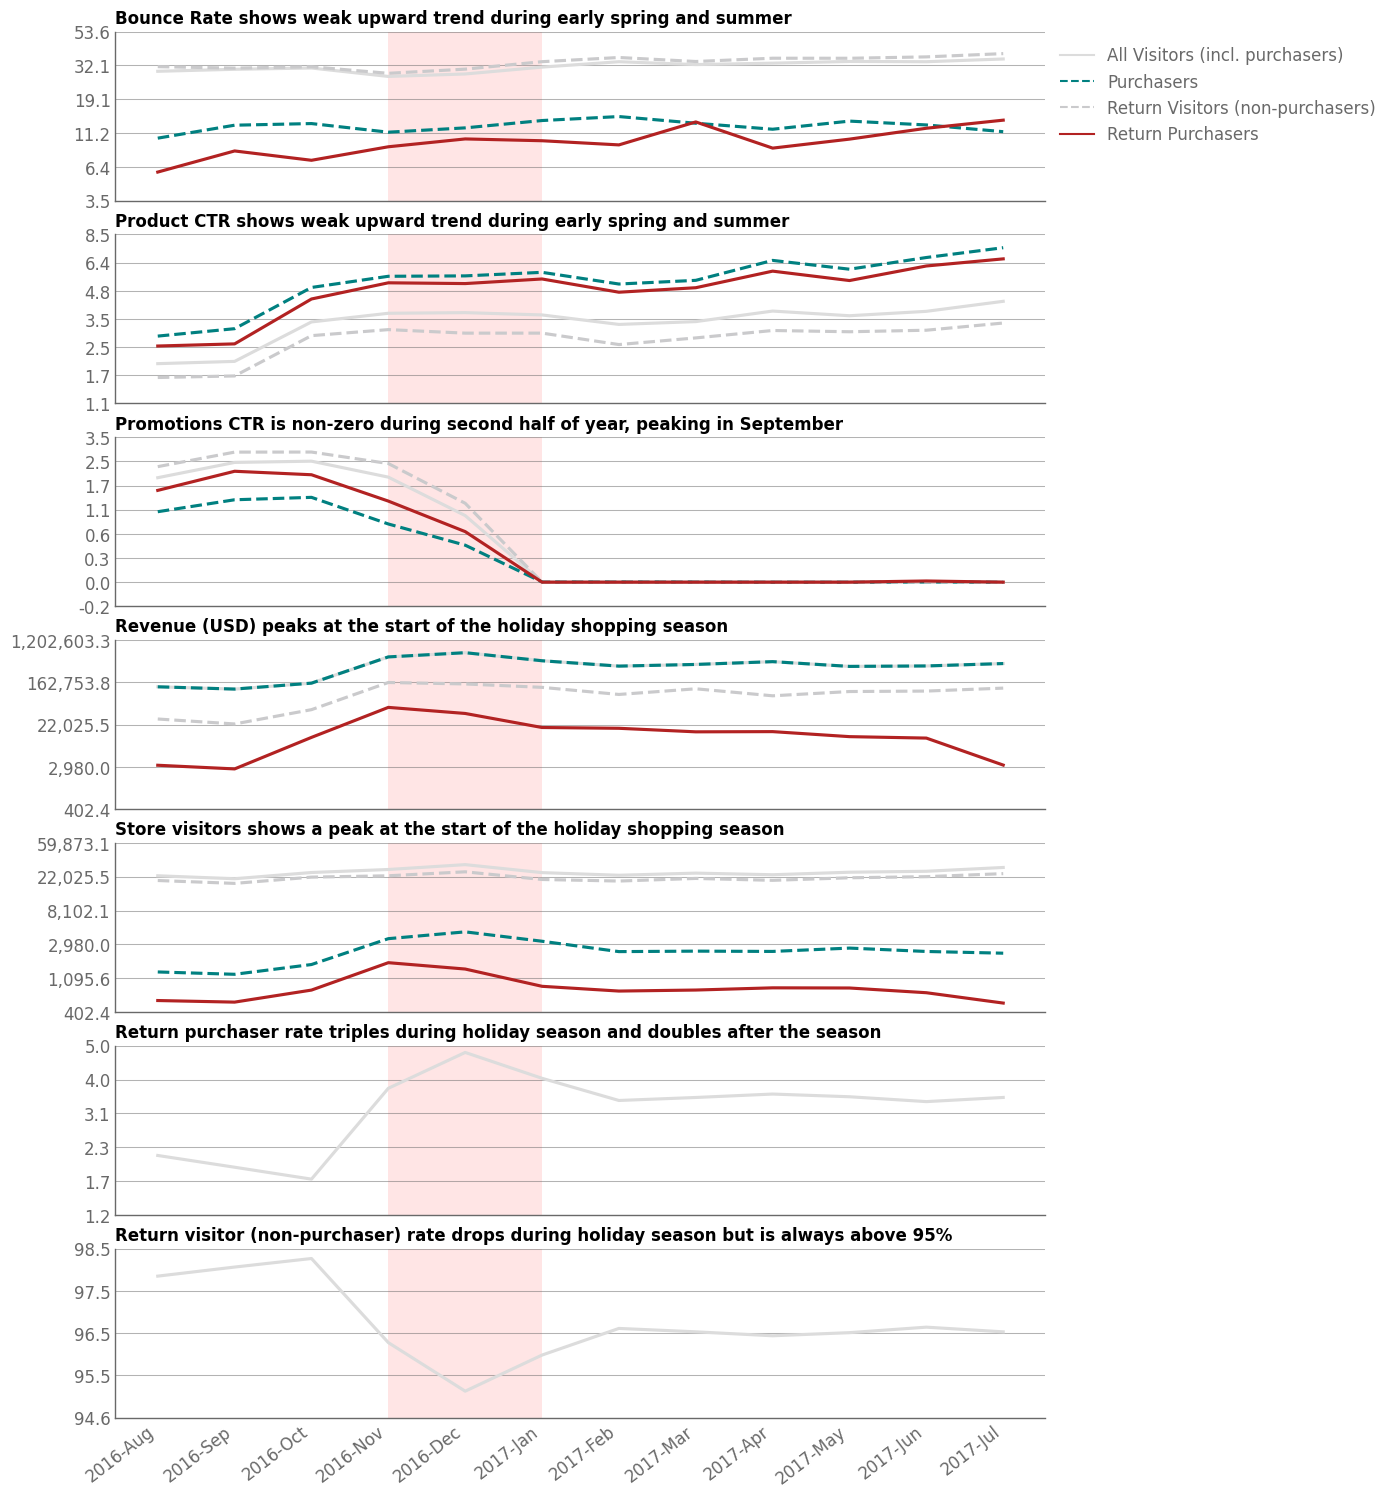

In [33]:
ptitles = {
    "bounce_rate": "Bounce Rate shows weak upward trend during early spring and summer",
    "product_ctr": "Product CTR shows weak upward trend during early spring and summer",
    "promos_ctr": "Promotions CTR is non-zero during second half of year, peaking in September",
    "revenue": "Revenue (USD) peaks at the start of the holiday shopping season",
    "visitors": "Store visitors shows a peak at the start of the holiday shopping season",
    "return_purchaser_rate": (
        "Return purchaser rate triples during holiday season and doubles after the season"
    ),
    "return_visitor_rate": (
        "Return visitor (non-purchaser) rate drops during holiday season but is always above 95%"
    ),
}

fig = plt.figure(figsize=(12, 18))
grid = plt.GridSpec(7, 1, hspace=0.2)
ax1 = fig.add_subplot(grid[0, 0], xticklabels=[])
ax2 = fig.add_subplot(grid[1, 0], xticklabels=[])
ax3 = fig.add_subplot(grid[2, 0], xticklabels=[])
ax4 = fig.add_subplot(grid[3, 0], xticklabels=[])
ax5 = fig.add_subplot(grid[4, 0], xticklabels=[])
ax6 = fig.add_subplot(grid[5, 0], xticklabels=[])
ax7 = fig.add_subplot(grid[6, 0])

colors = ["gainsboro", 'teal', "#cacacc", "firebrick"]
linestyles = ["-", "--", "--", "-"]
labels = [
    "All Visitors (incl. purchasers)",
    'Purchasers',
    "Return Visitors (non-purchasers)",
    "Return Purchasers",
]
lines = [
    Line2D([0, 1], [0, 1], linestyle=l, color=c)
    for c, l in zip(colors, linestyles)
]

for k, (variable, ax, show_legend) in enumerate(
    zip(list(ptitles), [ax1, ax2, ax3, ax4, ax5, ax6, ax7], [True] + ([False]*(len(ptitles)-1)))
):
    data = (
        df_visitors.query(f"variable == '{variable}'").drop(columns=['variable'])
        .assign(value=lambda df: np.log1p(df['value']))
    )
    xvalues = data['visitor_type'].unique().tolist()
    linestyles_sliced, colors_sliced, lines_sliced, labels_sliced = [
        linestyles[:len(xvalues)],
        colors[:len(xvalues)],
        lines[:len(xvalues)],
        labels[:len(xvalues)],
    ]

    ax = sns.lineplot(
        data=data,
        x='year_month',
        y='value',
        linewidth=2.25,
        hue='visitor_type',
        palette=colors_sliced,
        ax=ax,
        zorder=10,
    )
    ticklabels = [
        f"{round(np.expm1(float(l.get_text().replace('−', '-'))), 1):,}"
        for l in ax.get_yticklabels()
    ]
    yticks = ax.get_yticks()
    _ = ax.set_yticks(yticks, ticklabels)
    for line, ls in zip(ax.get_lines(), linestyles_sliced):
        line.set_linestyle(ls)
    ax.axvspan('2016-Nov', '2017-Jan', facecolor='red', alpha=0.1)
    vh.customize_plot(
        ax,
        dict(
            handles=lines_sliced,
            labels=labels_sliced,
            ncols=1,
            loc="upper left",
            bbox_to_anchor=(1, 1),
            frameon=False,
            prop={"size": 12},
        ),
        ptitle=ptitles[variable],
        x_tick_angle = 37.5,
        axis_tick_label_fontsize = 12,
        grid_thickness = 0.75,
        grid_opacity = 0.5,
        line_color = 'dimgrey',
        show_grid = True,
        show_legend=show_legend,
    )

::: {.callout-note title="Notes"}

1. The following are the types of visitors shown on this plot
   - <span style="color:#a2a3a3"><b>Visitors</b></span>
     - all visits by visitors who did or did not make a purchase during an initial and/or return visit
   - <span style="color:teal"><b>Purchasers</b> (dashed)</span>
     - all visits by visitors who did make a purchase during an initial and/or return visit
   - <span style="color:#898c8b"><b>Return Visitors</b> (dashed)</span>
     - first visit by visitors who returned but did not make a purchase on the return visit
     - these visitors might have made a purchase on their first visit, so the first visit `revenue` is not necessarily 0 for these visitors
   - <span style="color:firebrick"><b>Return Purchasers</b></span>
     - first visit by visitors who returned and did make a purchase on the return visit
     - these visitors made a purchase on their first visit, so the first visit `revenue` is never 0 for these visitors
:::

::: {.callout-tip title="Observations"}

1. Except for Sep - Dec, all KPIs are relatively unchanged, with weak upward trends seen in
   - Bounce Rate
   - Product CTR

   Importantly, this means
   - Revenue
   - Return Purchaser Rate

   do not show signs of growth.
2. Among return purchasers
   - Bounce Rate (3X to 5X lower)
   - Product CTR (higher)

   consistently outperform their corresponding monthly values when all visitors (including non-return purchasers) are taken into account.
:::